# ARIMA

In [163]:
import pandas as pd
from pandas import read_csv
import numpy as np
from datetime import datetime
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf

/usr/lib64/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Brazil wage average from January 2012 to September 2019

Cleaning data

In [221]:
data = pd.read_csv('wage_brazil_20190929053435.csv',sep=';',header=1)

In [222]:
wage = data.T

In [223]:
wage.drop(wage.index[0],inplace=True)
wage[0] = wage[0].astype(float)

In [252]:
#wage.drop(wage[1])
wage.head()

,0,1
jan-fev-mar 2012,2175.0,NaN
fev-mar-abr 2012,2186.0,NaN
mar-abr-mai 2012,2178.0,NaN
abr-mai-jun 2012,2183.0,NaN
mai-jun-jul 2012,2194.0,NaN


In [225]:
len(wage)

90

In [269]:
df = pd.DataFrame({'date': pd.date_range(start='1/1/2012', end='1/09/2019', periods=len(wage)).normalize(), 'wage': wage[0]})
df.reset_index(inplace=True)
df.set_index('date',inplace=True)
df.drop(columns='index',inplace=True)
df.head()

,wage
date,
2012-01-01,2175.0
2012-01-29,2186.0
2012-02-27,2178.0
2012-03-27,2183.0
2012-04-25,2194.0


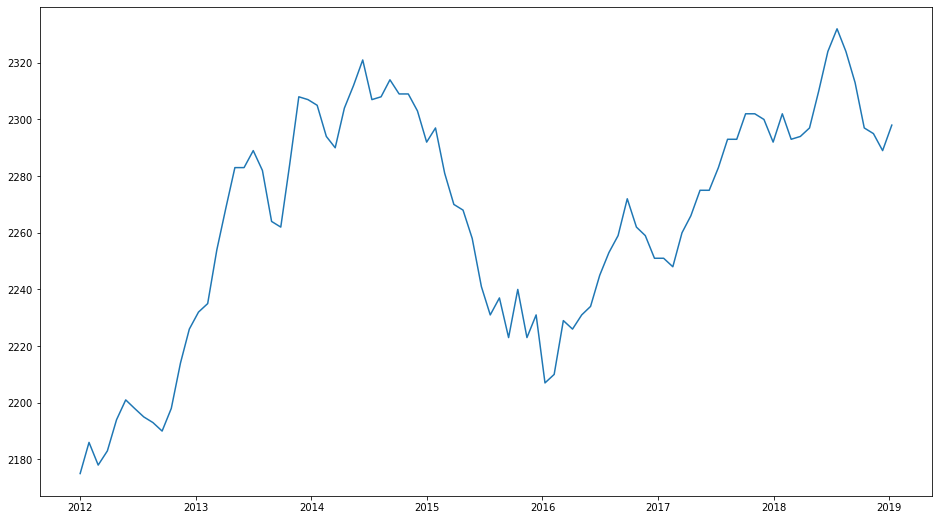

In [270]:
plt.figure(figsize=(16,9))
plt.plot(df)
plt.show()

In [169]:
def stationarity_test(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(16,9))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

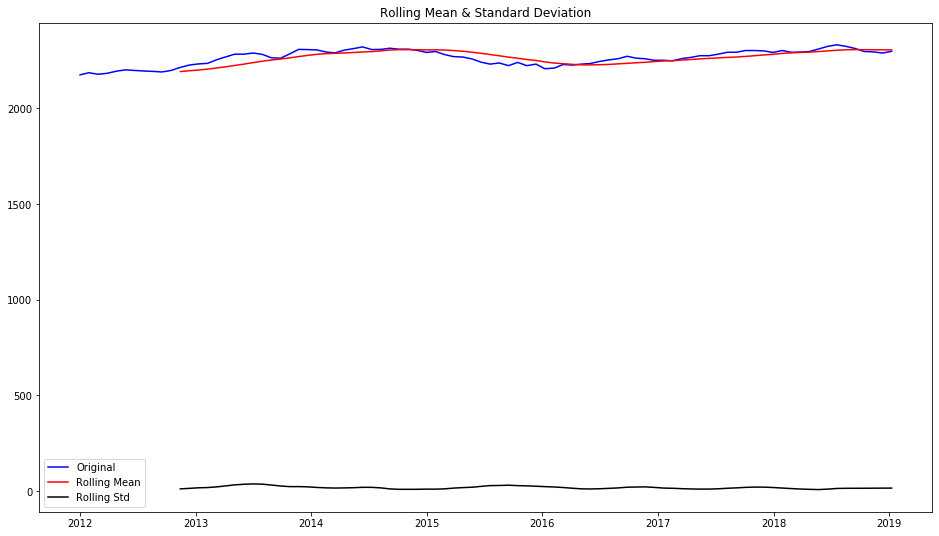

In [271]:
stationarity_test(df)

In [275]:
def difference(dataset, interval=1):
    index = list(dataset.index)
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset['wage'][i] - dataset['wage'][i - interval]
        diff.append(value)
    return (diff)

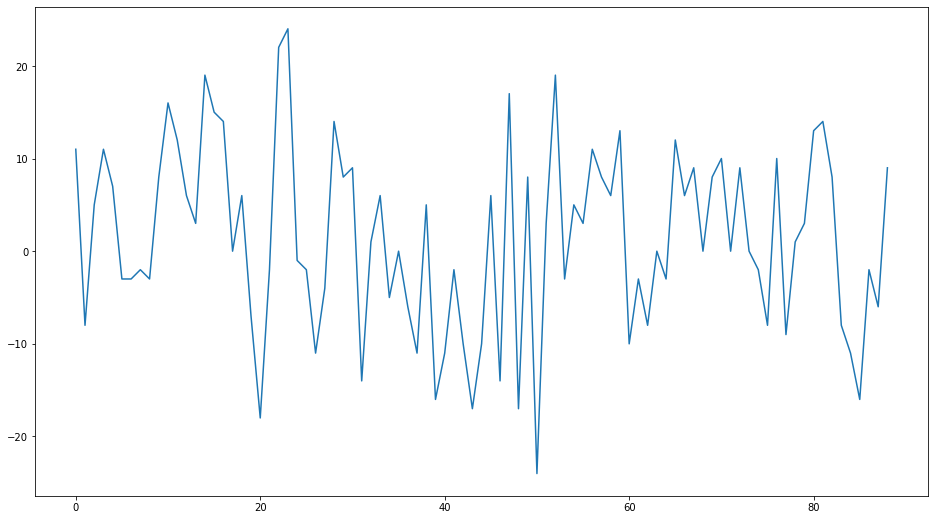

In [276]:
diff = difference(df)
plt.figure(figsize=(16,9))
plt.plot(diff)
plt.show()

Transformation

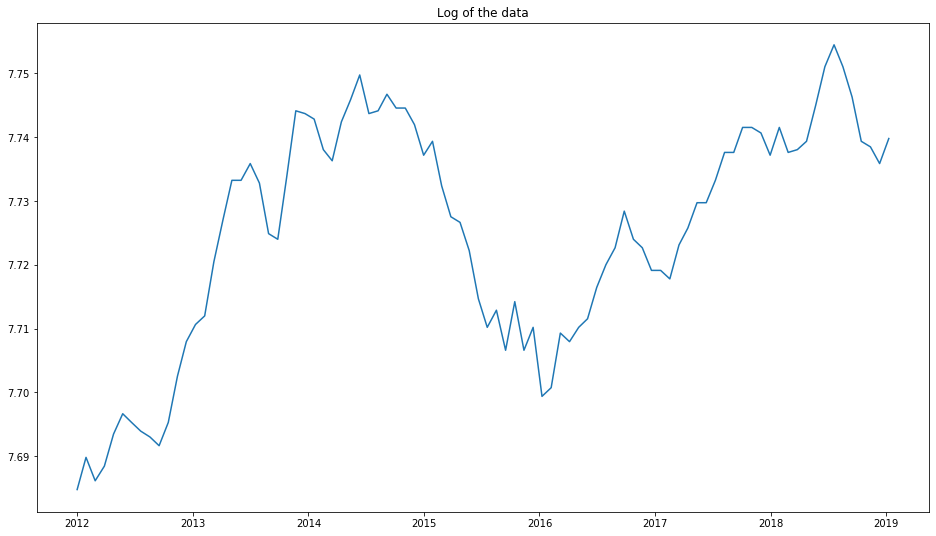

In [296]:
log_value = pd.DataFrame({'date':df.index, 'wage':np.log(df.wage)})
plt.figure(figsize=(16,9))
plt.title('Log of the data')
plt.plot(log_value.wage)
plt.show()

## Moving Average

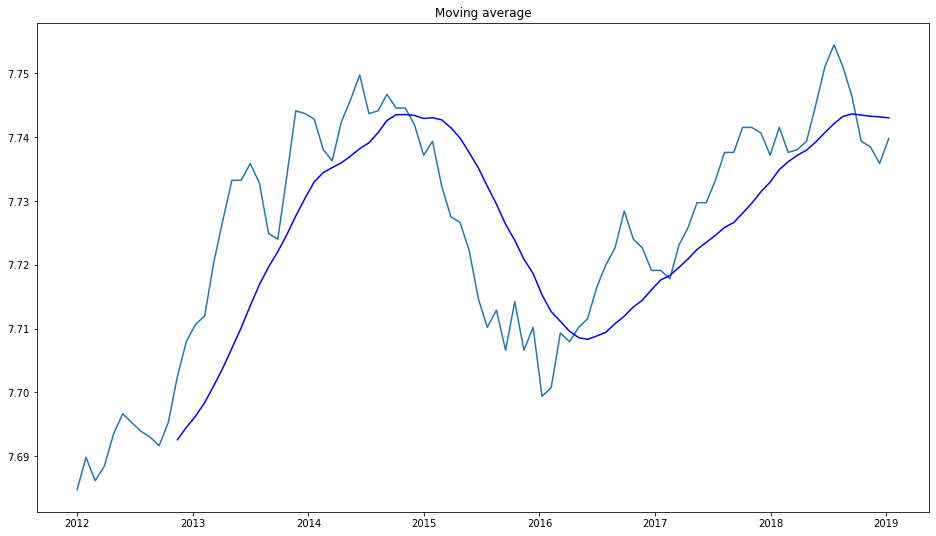

In [298]:
moving_avg = log_value.rolling(12).mean()
plt.figure(figsize=(16,9))
plt.plot(log_value.wage)
plt.title('Moving average')
plt.plot(moving_avg, color='blue')
plt.show()

In [303]:
log_moving_avg_diff = log_value.wage - moving_avg.wage

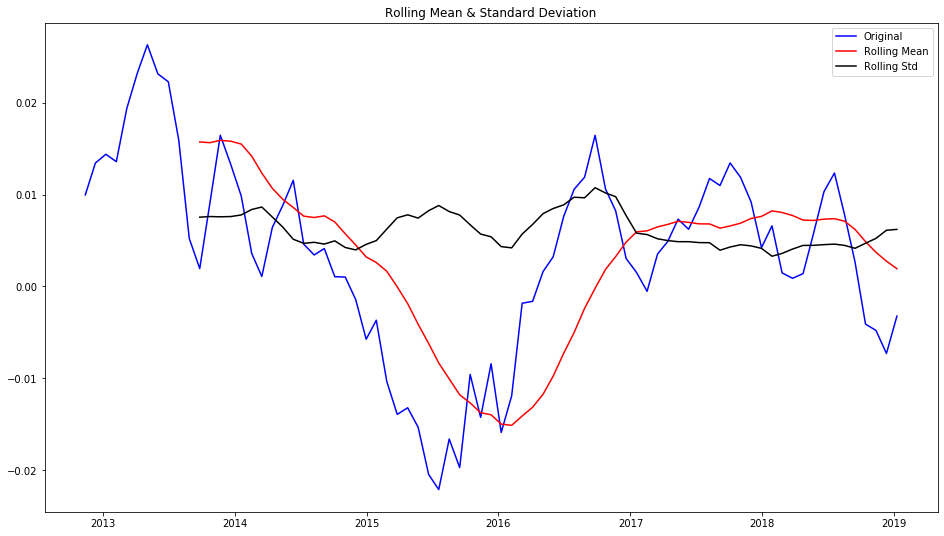

In [304]:
log_moving_avg_diff.dropna(inplace=True)
stationarity_test(log_moving_avg_diff)

Weighted Moving Average

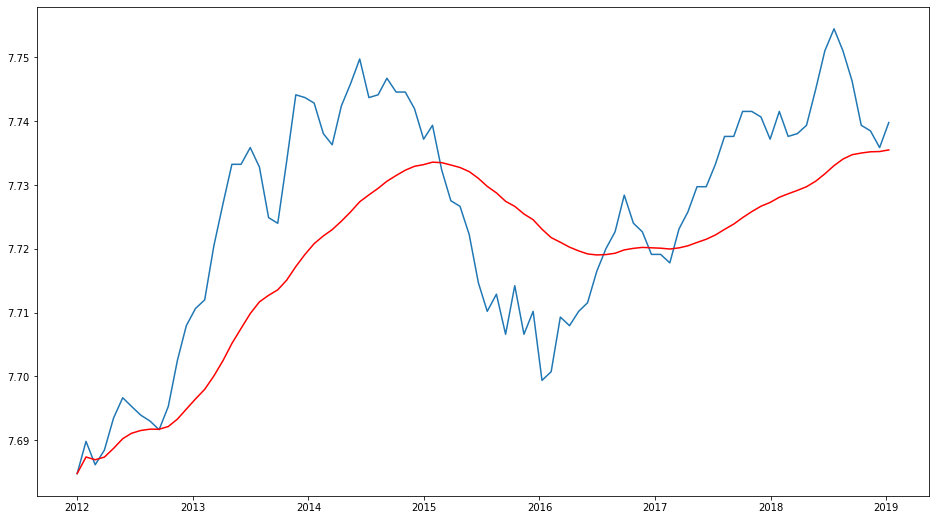

In [307]:
expwighted_avg = log_value.ewm(halflife=12).mean()
# halflife is used to define the amount of exponential decay
plt.figure(figsize=(16,9))
plt.plot(log_value.wage)
plt.plot(expwighted_avg, color='red')
plt.show()

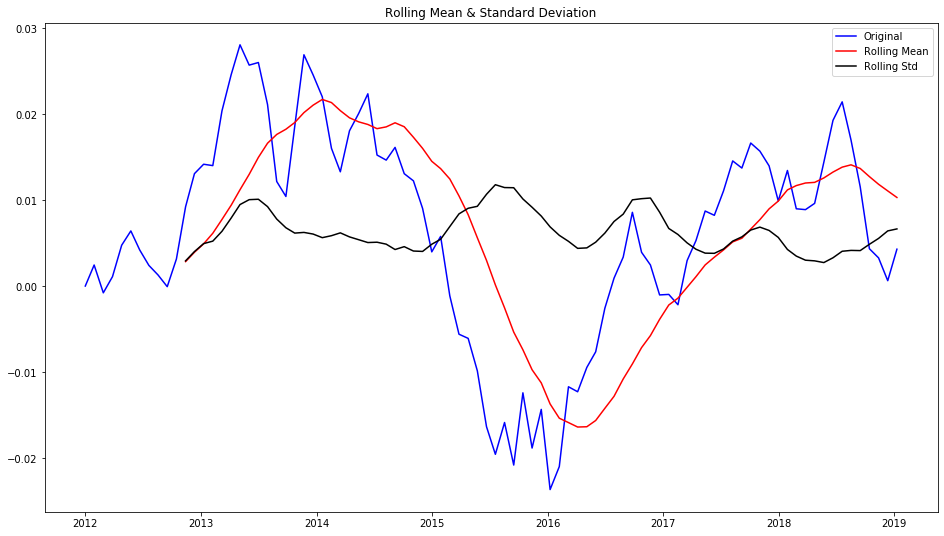

In [309]:
log_ewma_diff = log_value.wage - expwighted_avg.wage
stationarity_test(log_ewma_diff)

## Eliminating Trend and Seasonality

## Differencing

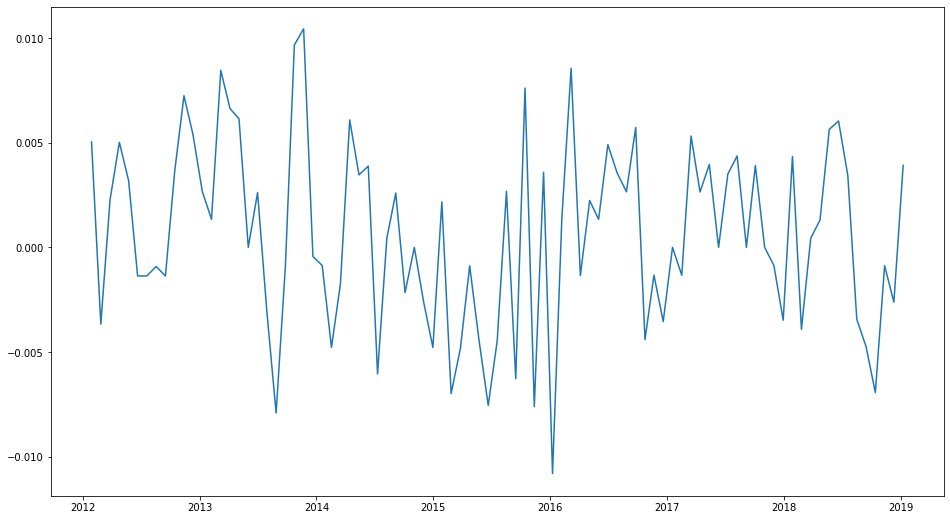

In [310]:
log_diff = log_value.wage - log_value.wage.shift()
plt.figure(figsize=(16,9))
plt.plot(log_diff)
plt.show()

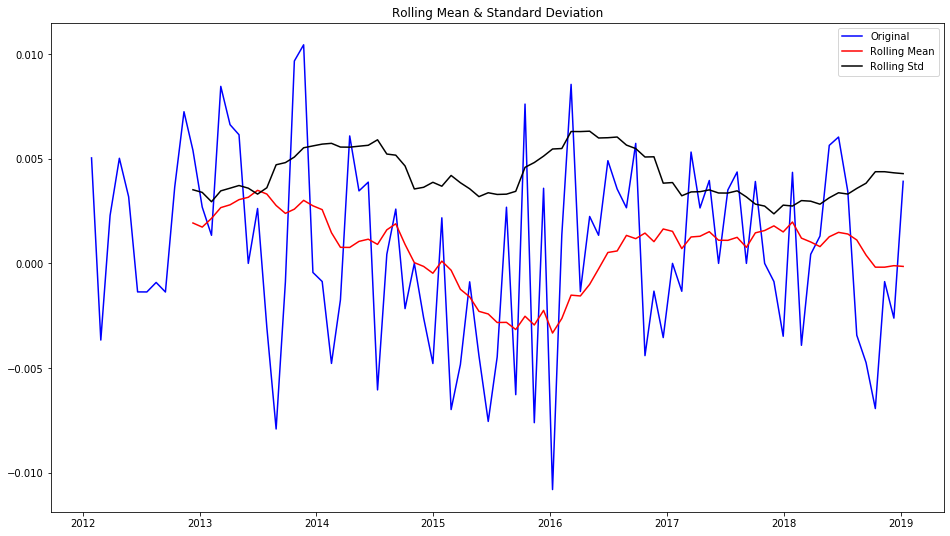

In [311]:
log_diff.dropna(inplace=True)
stationarity_test(log_diff)

## Decomposition

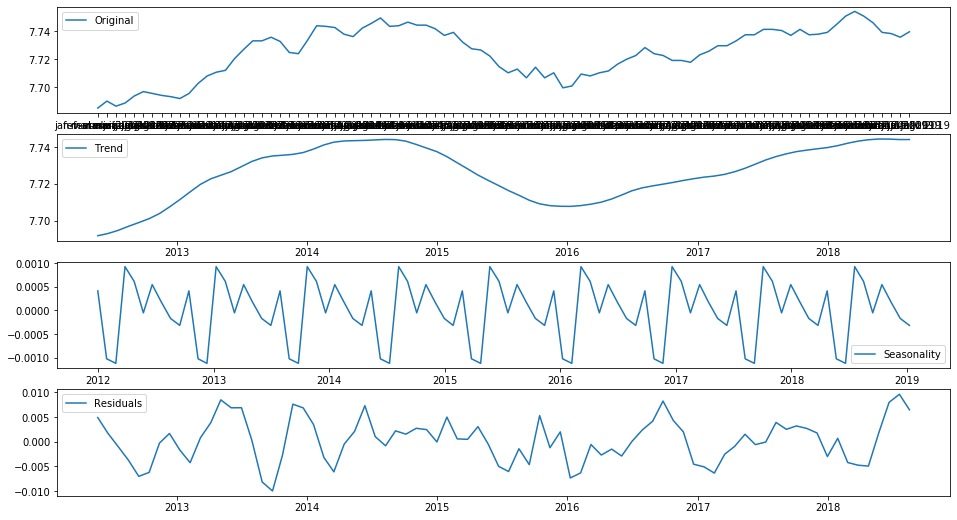

<Figure size 432x288 with 0 Axes>

In [313]:
from statsmodels.tsa.seasonal import seasonal_decompose

#log_value['Date'] = pd.to_datetime(log_value['Date'])
#s = sm.tsa.seasonal_decompose(ts_log_index.Wage)

decomposition = seasonal_decompose(log_value.wage, freq = 10)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,9))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()
plt.tight_layout()

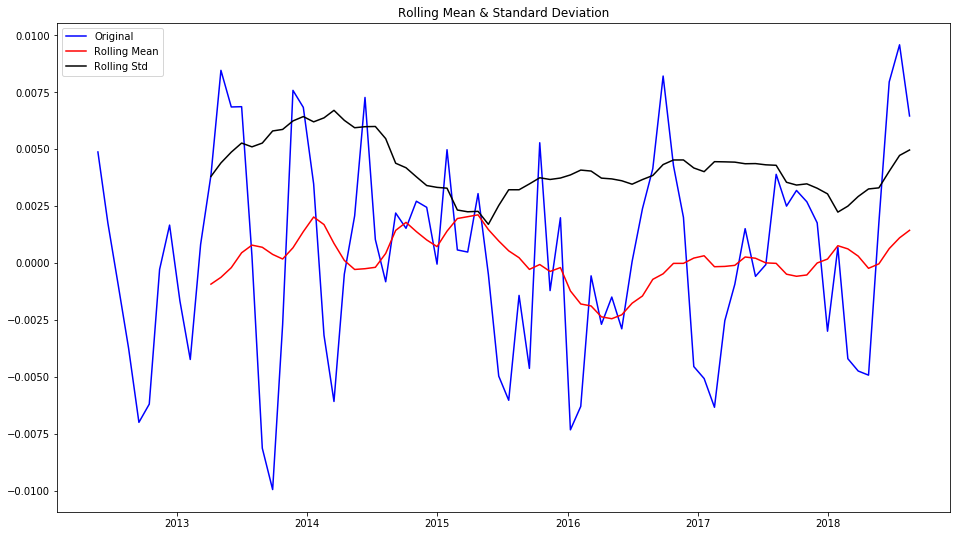

In [314]:
log_decompose = residual
log_decompose.dropna(inplace=True)
stationarity_test(log_decompose)

/home/danilopena/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


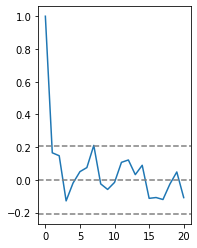

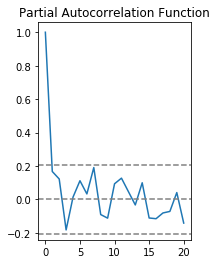

<Figure size 432x288 with 0 Axes>

In [315]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(log_diff, nlags=20)
lag_pacf = pacf(log_diff, nlags=20, method='ols')

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_diff)),linestyle='--',color='gray')
plt.show()
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()
plt.tight_layout()

## AR Model

/home/danilopena/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/danilopena/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


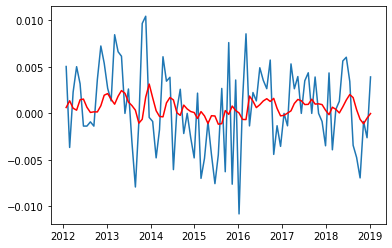

In [317]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(log_value.wage, order=(2, 1, 0), freq=log_value.index.inferred_freq)
results_AR = model.fit(disp=-1)  
plt.plot(log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.show()

## MA Model

/home/danilopena/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/danilopena/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


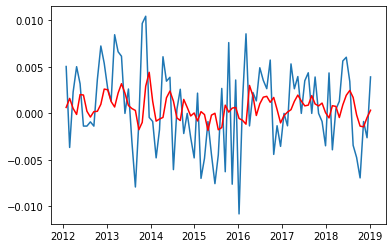

In [323]:
model = ARIMA(log_value.wage, order=(0, 1, 2), freq=log_value.index.inferred_freq)  
results_MA = model.fit(disp=-1)  
plt.plot(log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.show()

/home/danilopena/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/danilopena/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


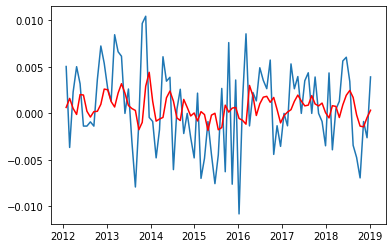

In [325]:
model = ARIMA(log_value.wage, order=(0, 1, 2), freq=log_value.index.inferred_freq)  
results_ARIMA = model.fit(disp=-1)
plt.plot(log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.show()